Shannon Moran <br>
Phys 514 <br>
HW 3<br>
Due: Sept 28

## Import required packages

In [1]:
%matplotlib inline
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import animation
import time

# Used for animation
from IPython.display import HTML

## Lennard Jones code supplied

In [2]:
def initialize_positions_and_velocities(rx,ry,vx,vy, Nx, Ny,L):
    dx=L/Nx;
    dy=L/Ny;
    np.random.seed(0)
    for i in range(Nx):
        for j in range(Ny):
            rx[i*Ny+j]=dx*(i+0.5)
            ry[i*Ny+j]=dy*(j+0.5)

            u=np.random.random() #This is box muller
            v=np.random.random()
            # Solves for velocities drawn from probability distribution (1.13)
            vx[i*Ny+j]=np.sqrt(-2*np.log(u))*np.cos(2.*np.pi*v)
            vy[i*Ny+j]=np.sqrt(-2*np.log(u))*np.sin(2.*np.pi*v)
    #subtract net velocity to avoid global drift
    vxav=sum(vx)/vx.size
    vyav=sum(vy)/vx.size
    vx-=vxav
    vy-=vyav

def potential(rsq):
    rsqinv=1./rsq
    r6inv=rsqinv*rsqinv*rsqinv
    return -4*r6inv*(1-r6inv)

def compute_kinetic_energy(vx,vy):
    return 0.5*sum(vx*vx+vy*vy)

def compute_potential_energy(rx,ry,rcut,L):
    rcutsq=rcut*rcut
    rcutv=potential(rcutsq) #shift the potential to avoid jump at rc
    Epot=0. 
    for i in range(rx.size):
        for j in range(i):
            dx=rx[i]-rx[j]
            dy=ry[i]-ry[j]
            #minimum image convention
            if(dx > L/2.): dx=dx-L
            if(dx <-L/2.): dx=dx+L
            if(dy > L/2.): dy=dy-L
            if(dy <-L/2.): dy=dy+L
            #print dx,dy
            #compute the distance
            rsq=dx*dx+dy*dy
            if(rsq < rcutsq):
                Epot+=potential(rsq)-rcutv
    return Epot
        
def compute_forces(rx,ry,dV_drx, dV_dry, N, L, rcut):
    rcutsq=rcut*rcut
    for i in range(N):
        for j in range(i):
            dx=rx[i]-rx[j] ; 
            dy=ry[i]-ry[j] ; 
            #minimum image convention
            if(dx > L/2.): dx=dx-L
            if(dx <-L/2.): dx=dx+L
            if(dy > L/2.): dy=dy-L
            if(dy <-L/2.): dy=dy+L
            #compute the distance
            rsq=dx*dx+dy*dy
            #check if we are < the cutoff radius
            if(rsq < rcutsq):
                #here is the call of the force calculation
                dV_dr=force(rsq)

                #here the force is being added to the particle. Note the additional dx
                dV_drx[i]+=dx*dV_dr
                dV_drx[j]-=dx*dV_dr
                dV_dry[i]+=dy*dV_dr
                dV_dry[j]-=dy*dV_dr
            
def euler(rx,ry,vx,vy,dV_drx,dV_dry,dt,L):
    #update the positions
    rx+=dt*vx
    ry+=dt*vy
    rebox(rx,ry,L)

    #update the velocities
    vx+=dt*dV_drx
    vy+=dt*dV_dry
    
#put back into box:
def rebox(rx,ry,L):
    for i in range(rx.size):
        if rx[i] > L:
            rx[i]=rx[i]-L
        if rx[i] < 0:
            rx[i]=rx[i]+L
        if ry[i] > L:
            ry[i]=ry[i]-L
        if ry[i] < 0:
            ry[i]=ry[i]+L

# I don't actually use this function-- sorry                
def print_result(rxlog,rylog,vxlog,vylog):
    fr=open("positions.dat",'w')
    fv=open("velocities.dat",'w')

    for j in range(rxlog.shape[1]):
        for i in range(rxlog.shape[0]):
            fr.write(str(rxlog[i,j])+" "+str(rylog[i,j])+'\n')
            fv.write(str(vxlog[i,j])+" "+str(vylog[i,j])+'\n')
    fr.write('\n')
    fv.write('\n')

In [3]:
# Just moved the main lj_start.py arguments into their own function.

def main(parameters,method):
    Ny = Nx = parameters['Nx']
    N = Nx*Ny
    L = parameters['L']
    
    # Simulation parameters
    rcut=2.5 # a usual choice for the cutoff radius
    dt = parameters['dt']
    t_run = parameters['t_run']
    Nstep=int(t_run/dt)

    vx=np.zeros(N)
    vy=np.zeros(N)
    rx=np.zeros(N)
    ry=np.zeros(N)

    rxlog=np.zeros([Nstep,N])
    rylog=np.zeros([Nstep,N])
    vxlog=np.zeros([Nstep,N])
    vylog=np.zeros([Nstep,N])

    Epot = np.zeros(Nstep)
    Ekin = np.zeros(Nstep)
    Etot = np.zeros(Nstep)

    initialize_positions_and_velocities(rx,ry,vx,vy,Nx,Ny,L)

    for i in range(Nstep):
        dV_drx=np.zeros(N)
        dV_dry=np.zeros(N)

        compute_forces(rx,ry,dV_drx,dV_dry, N, L, rcut)

        # Note that rebox is called within the euler and verlet functions
        if method=='Euler':
            euler(rx,ry,vx,vy,dV_drx,dV_dry,dt,L)
        elif method=='Verlet':
            verlet(rx,ry,vx,vy,dV_drx,dV_dry,dt,N,L,rcut)
        else: pass

        rxlog[i]=rx
        rylog[i]=ry
        vxlog[i]=vx
        vylog[i]=vy

        Epot[i] = compute_potential_energy(rx,ry,rcut,L)
        Ekin[i] = compute_kinetic_energy(vx,vy)
        Etot[i] = Epot[i]+Ekin[i]

    plt.plot(range(0,Nstep,int(1e3)),Etot[::int(1e3)])
    plt.title('Total energy over time, %s method' %method)
    plt.xlabel('step')
    plt.show()
    return rxlog, rylog

## 1: Implement Lennard Jones simulation
Lennard Jones potential is given by:
$$ U_{ij}^{(LJ)}(r) = 4\epsilon_{ij}\left[\left(\frac{\sigma}{r}\right)^{12}-\left(\frac{\sigma}{r}\right)^6\right]$$

The force generated by a potential $U(r)$ is simply:
$$ F = -\frac{\partial U}{\partial r} $$

So the force generated by the Lennard Jones potential is:
$$ F(r) = \frac{48\epsilon}{r^2}\left(\left(\frac{\sigma}{r}\right)^{12}-0.5*\left(\frac{\sigma}{r}\right)^6\right) $$

In [4]:
def force(rsq):
    '''
    Note that this returns F=-dU/dr
    This requires re-writing the euler() provided, to add dt*dV_dr rather than subtract
    '''
    # Set constants
    epsilon = 1
    sigma = 1
    r = sqrt(rsq)
    
    # Solve for force
    F = (48*epsilon)/r**2*((sigma/r)**12-0.5*(sigma/r)**6)
    return F

dt = 0


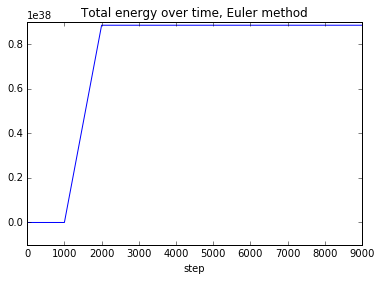

dt = 0


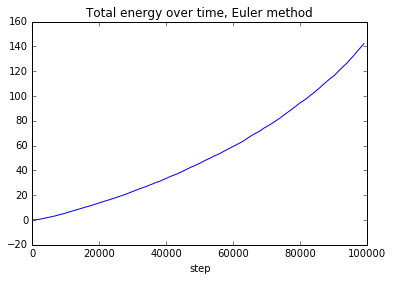

In [5]:
euler_parameters = {
    'dt': 1e-3,
    't_run': 10,
    'Nx': 6,
    'L': 6,
}

print('dt = %d' % euler_parameters['dt'])
_,_ = main(euler_parameters,'Euler')

'''
However, this is not stable (energy 'blows up').
By decreasing dt, we can slow the blow up, but not totally prevent it.
'''
euler_parameters['dt'] = 1e-4
print('dt = %d' % euler_parameters['dt'])
_,_ = main(euler_parameters,'Euler')

## 2: Implement the velocity verlet algorithm

In [6]:
def verlet(rx,ry,vx,vy,dV_drx,dV_dry,dt,N,L,rcut):
    #update the positions
    rx += dt*vx + 0.5*dt**2*(dV_drx)
    ry += dt*vy + 0.5*dt**2*(dV_dry)

    rebox(rx,ry,L)

    dV_drx_next = np.zeros(N)
    dV_dry_next = np.zeros(N)

    compute_forces(rx,ry,dV_drx,dV_dry, N, L, rcut)
    
    vx += 0.5*dt*(dV_drx+dV_drx_next)
    vy += 0.5*dt*(dV_dry+dV_dry_next)

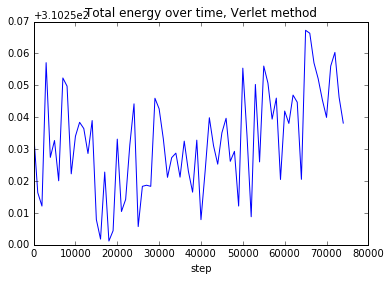

In [7]:
solid_parameters = {
    'dt': 1e-3,
    't_run': 75,
    'Nx': 6,
    'L': 5.5,
    'phase': 'Solid',
}
rxlog_s, rylog_s = main(solid_parameters,'Verlet')

We can access a fluid phase by simply reducing the density of the system (shown below). The before/after value of L was reached by guess and check.

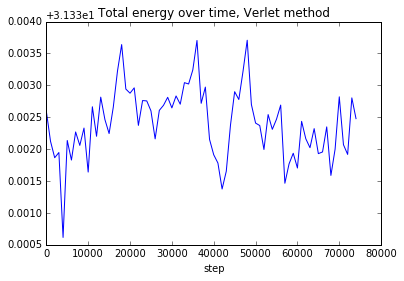

In [8]:
fluid_parameters = {
    'dt': 1e-3,
    't_run': 75,
    'Nx': 6,
    'L': 12,
    'phase': 'Fluid',
}
rxlog_f, rylog_f = main(fluid_parameters,'Verlet')

## 3: Measurements
Examine the trajectories of your molecules. Find a region of phase space where the system is solid and another one where it is fluid.

Here, I animate the trajectories to visualize the system behavior. Note that Vyas Ramasubramani, Luis Rivera-Rivera, Pengji Zhou, Will Zygmunt and I all have very similar implementations of this animation. We worked together to learn and then trouble-shoot matplotlib animation!

In [18]:
# Visualize solid

parameters = solid_parameters

L = parameters['L']
dt = parameters['dt']
t_run = parameters['t_run']
N = parameters['Nx']**2
Nstep=int(t_run/dt)
phase = parameters['phase']

fig = plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(0, L), ylim=(0, L))
ani_jump = 1e3

def pull_positions_solid(i):
    global ani_jump, rxlog_s, rylog_s, N, dt
    ax.clear()
    j = i*ani_jump
    for n in range(N):
        if n%2==0:
            particles = plt.Circle((rxlog_s[j,n],rylog_s[j,n]),0.47,fc="#00274c")
        else:
            particles = plt.Circle((rxlog_s[j,n],rylog_s[j,n]),0.47,fc="#ffcb05")
        ax.add_patch(particles)
    ax.set_title("Solid: t = %s" %(j*dt));
    return []

ani = animation.FuncAnimation(fig, pull_positions_solid, frames=np.arange(0,int(Nstep/ani_jump)),interval=100,blit=True)
plt.close()

HTML(ani.to_html5_video())

/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [19]:
# Vizualize fluid

parameters = fluid_parameters

L = parameters['L']
dt = parameters['dt']
t_run = parameters['t_run']
N = parameters['Nx']**2
Nstep=int(t_run/dt)
phase = parameters['phase']

fig = plt.figure(figsize=(5,5))
ax = plt.axes(xlim=(0, L), ylim=(0, L))
ani_jump = 1e3

def pull_positions_fluid(i):
    global ani_jump, rxlog_f, rylog_f, N, dt
    ax.clear()
    j = i*ani_jump
    for n in range(N):
        if n%2==0:
            particles = plt.Circle((rxlog_f[j,n],rylog_f[j,n]),0.47,fc="#00274c")
        else:
            particles = plt.Circle((rxlog_f[j,n],rylog_f[j,n]),0.47,fc="#ffcb05")
        ax.add_patch(particles)
    ax.set_title("Fluid: t = %s" %(j*dt));
    return []

ani = animation.FuncAnimation(fig, pull_positions_fluid, frames=np.arange(0,int(Nstep/ani_jump)),interval=100,blit=True)
plt.close()

HTML(ani.to_html5_video())

/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Next, I plot both the RMSD and self-diffusion coefficient, D, as function of time to show the difference between the fluid and the solid.

In [9]:
# Update rebox to work for distances.
def rebox_D(dx,dy,L):
    for i in range(dx.size):
        if dx[i] > L:
            dx[i]=dx[i]-L
        if dx[i] < -L:
            dx[i]=dx[i]+L
        if dy[i] > L:
            dy[i]=dy[i]-L
        if dy[i] < -L:
            dy[i]=dy[i]+L

In [26]:
def rmsd(parameters, tstart, rxlog, rylog):
    L = parameters['L']
    dt = parameters['dt']
    t_run = parameters['t_run']
    phase = parameters['phase']
    N = parameters['Nx']**2
    t_range = np.arange(0.0,t_run,0.1)
    t_range_therm = np.arange(tstart,t_run,0.1)
    #t0 = tstart/dt
    diffusion = []
    rmsd = []
    
    for t in t_range:
        j = t/dt
        dx = rxlog[j,:]-rxlog[0,:]
        dy = rylog[j,:]-rylog[0,:]
        rebox_D(dx,dy,L/2)
        r = np.sqrt((dx)**2+(dy)**2)
        rmsd_value = (1/N)*np.sum(r)
        rmsd.append(rmsd_value)
        diffusion.append(rmsd_value/4*t)

    # Plot rmsd
    plt.plot(t_range,rmsd,'bo')
    m, b = np.polyfit(t_range_therm,rmsd[-len(t_range_therm):], 1)
    plt.plot(t_range_therm, t_range_therm*m + b, 'r-', lw="2")
    print('slope: %s' %m)
    plt.title('%s: RMSD over time (thermalized system)' %phase)
    plt.xlabel('time (t)')
    plt.ylabel('Root-mean-squared displacement (RMSD)')
    plt.show()
    
    # Plot self-diffusion coefficient
    plt.plot(t_range,diffusion,'bo')
    m, b = np.polyfit(t_range_therm,diffusion[-len(t_range_therm):], 1)
    plt.plot(t_range_therm, t_range_therm*m + b, 'r-', lw="2")
    print('slope: %s' %m)
    plt.title('%s: Self-diffusion over time (thermalized system)' %phase)
    plt.xlabel('time (t)')
    plt.ylabel('Self-diffusion coefficient')
    plt.show()
    return

slope: 0.00328409974106


/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


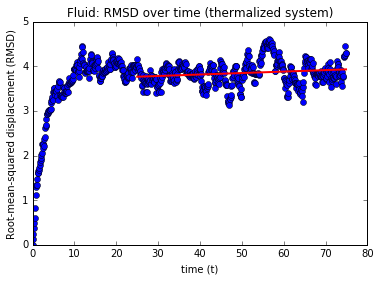

slope: 0.997080975798


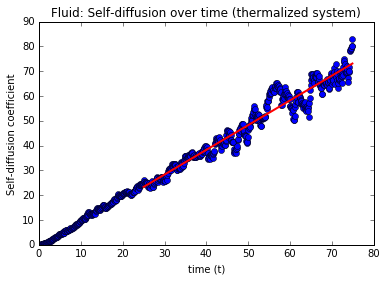

slope: -4.50300019914e-05


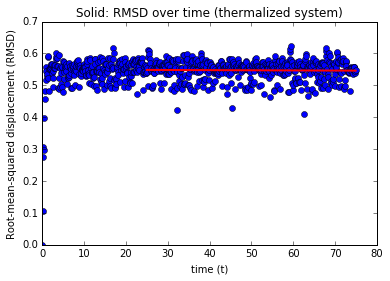

slope: 0.136531824505


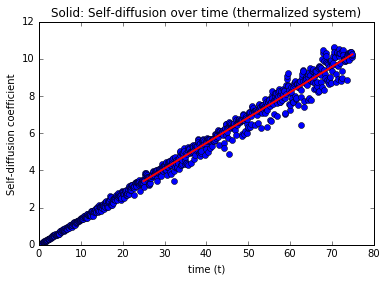

In [27]:
# Time to thermalize: estimated as 25s
t_therm = 25.0
rmsd(fluid_parameters, t_therm, rxlog_f, rylog_f)
rmsd(solid_parameters, t_therm, rxlog_s, rylog_s)

A few notes on this. In a solid, the self-diffusion coefficient (slope) should be zero. This is not quite the case here! It may be that I need to run the simulation for longer, compress the box slightly more, etc. The self-diffusion in the fluid nicely scales with time.

Also, while the RMSD for the solid is clearly constant, the fluid's RMSD once thermalized has clear peaks and valleys. This is likely due to particles crossing the box boundary; unless I looked at this over a timescale shorter than that of a particle crossingt the box length, this is not particularly useful.

## 4: Measurements II: $g(r)$
Measure the angle pair correlation function g(r) in both the solid and fluid cases, plotted as a function of r.

In [16]:
def pair_corr(parameters, t0, rxlog, rylog):
    L = parameters['L']
    phase = parameters['phase']
    t_run = parameters['t_run']
    N = parameters['Nx']**2

    dt_samples = 0.1
    dr = 0.1
    t_range = np.arange(t0,t_run,dt_samples)
    r_range = np.arange(0.5,L*sqrt(2)/2,dr)
    g_time = []
    for t in t_range:
        j = t/dt_samples
        particle_bins = []
        for i in range(N):
            dx = rxlog[j,:]-rxlog[j,i]
            dy = rylog[j,:]-rylog[j,i]
            rebox_D(dx,dy,L/2)
            r = np.sqrt((dx)**2+(dy)**2)
            hist, _ = np.histogram(r,bins=r_range)
            particle_bins.append(hist)
        g_time.append(np.mean(np.asarray(particle_bins),axis=0))
    g_r = np.mean(np.asarray(g_time),axis=0)
    plt.plot(r_range[:-1],g_r)
    plt.title('%s: g(r), averaged over thermalized samples' % phase)
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.show()
    return

/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shannonmoran/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


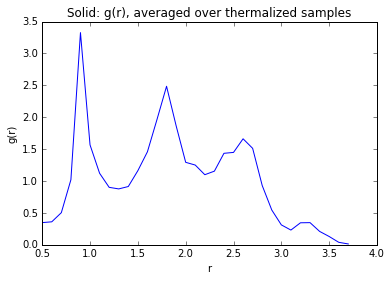

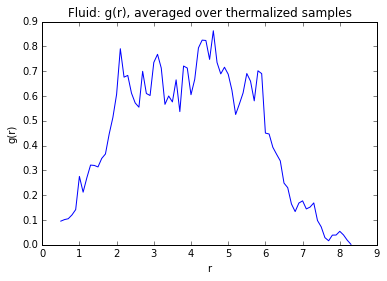

In [17]:
t_therm = 25.0
pair_corr(solid_parameters,t_therm,rxlog_s,rylog_s)
pair_corr(fluid_parameters,t_therm,rxlog_f,rylog_f)